In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [59]:
#df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv") 
#X = df.drop("purchaseValue", axis=1) 
#y = df['purchaseValue'] 
#from sklearn.dummy import DummyRegressor 
#model = DummyRegressor().fit(X,y) 
#X_test = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv") 
#y_pred=model.predict(X_test) 
#submission = pd.DataFrame({"id": range(0,X_test.shape[0]), "purchaseValue": y_pred}) 
#submission.to_csv('submission.csv',index=False)

# 1. Importing basic libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Importing other necassary libraries

In [61]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

import warnings
warnings.filterwarnings('ignore')

# 3.Data loading and Preprocessing and EDA

# 3.1 Importing the dataset

In [62]:
tr_data=pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")

In [63]:
print("Train dataset shape:",tr_data.shape)

Train dataset shape: (116023, 52)


In [64]:
te_data=pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

In [65]:
print("Test dataset shape:",te_data.shape)

Test dataset shape: (29006, 51)


# 3.2 Preprocessing

In [66]:
#Concise summary of the dataset
tr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [67]:
# Displays top 5 features if the dataset.

tr_data.head()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0


# 3.2.1 Converting dates from string to datatime object.

In [68]:
tr_dates = pd.to_datetime(tr_data['date'], format='%Y%m%d')
te_dates = pd.to_datetime(te_data['date'], format='%Y%m%d')

# 3.2.2 Removing duplicate rows
.


In [69]:
#Droppping duplicate rows to prevent data leakage
tr_data = tr_data.drop_duplicates()
print(f"Train dataset shape after duplicates removal: {tr_data.shape}")

Train dataset shape after duplicates removal: (115787, 52)


# 3.2.3 Handling Missing Values

In [70]:
missing_data = tr_data.isnull().sum()
missing_data_percentage = (missing_data / len(tr_data)) * 100
print("Missing value %:")
print(missing_data_percentage.sort_values(ascending=False))

Missing value %:
trafficSource.adContent                         97.442718
trafficSource.adwordsClickInfo.isVideoAd        96.313058
trafficSource.adwordsClickInfo.page             96.313058
trafficSource.adwordsClickInfo.adNetworkType    96.313058
trafficSource.adwordsClickInfo.slot             96.313058
trafficSource.referralPath                      63.132303
trafficSource.isTrueDirect                      63.089984
trafficSource.keyword                           61.949096
totals.bounces                                  59.303721
new_visits                                      30.566471
pageViews                                        0.006909
device.mobileInputSelector                       0.000000
date                                             0.000000
geoNetwork.city                                  0.000000
screenSize                                       0.000000
geoNetwork.metro                                 0.000000
locationZone                                     0.0000

# Dropping high cardanality and high missing % values columns.

In [71]:
drop_cols = ['sessionId', 'referralPath', 'trafficSource.adContent', 
             'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.isVideoAd', 
             'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.page']

for col in drop_cols:
    if col in tr_data.columns:
        tr_data.drop(col, axis=1, inplace=True)
    if col in te_data.columns:
        te_data.drop(col, axis=1, inplace=True)

# 3.2.4 Droping single value columns

In [72]:
# Identify and remove columns that contain only a single unique value
def single_value_columns(df):
    return [col for col in df.columns if df[col].nunique() <= 1]

tr_single = single_value_columns(tr_data)
te_single = single_value_columns(te_data)

# Combine both lists, remove duplicates
single_value_cols = list(set(tr_single + te_single))

print("Dropping these single-value columns:", single_value_cols)

for col in single_value_cols:
    if col in tr_data.columns:
        tr_data.drop(col, axis=1, inplace=True)
    if col in te_data.columns:
        te_data.drop(col, axis=1, inplace=True)

Dropping these single-value columns: ['device.screenResolution', 'screenSize', 'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize', 'device.mobileDeviceModel', 'device.mobileDeviceBranding', 'device.language', 'new_visits', 'locationZone', 'totals.visits', 'device.mobileInputSelector', 'totals.bounces', 'device.browserVersion', 'device.flashVersion', 'device.screenColors', 'trafficSource.isTrueDirect', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'socialEngagementType']


In [73]:
print(f"Train dataset shape after duplicates removal: {tr_data.shape}")
print(f"Test dataset shape after duplicates removal: {te_data.shape}")

Train dataset shape after duplicates removal: (115787, 26)
Test dataset shape after duplicates removal: (29006, 25)


In [74]:
# For numerical column data description
tr_data.describe()

,purchaseValue,userId,gclIdPresent,sessionNumber,pageViews,date,totalHits,sessionStart
count,1.157870e+05,115787.000000,115787.000000,115787.000000,115779.000000,1.157870e+05,115787.000000,1.157870e+05
mean,2.642244e+07,61096.345704,0.036990,2.691805,8.381330,2.016860e+07,10.565936,1.493441e+09
std,2.051726e+08,35240.261576,0.188739,10.461609,14.299764,6.184992e+03,19.558840,1.529498e+07
min,0.000000e+00,0.000000,0.000000,1.000000,1.000000,2.016080e+07,1.000000,1.470035e+09
25%,0.000000e+00,30602.500000,0.000000,1.000000,1.000000,2.016112e+07,1.000000,1.480068e+09
50%,0.000000e+00,61016.000000,0.000000,1.000000,2.000000,2.017041e+07,2.000000,1.491658e+09
75%,0.000000e+00,91621.500000,0.000000,2.000000,10.000000,2.017091e+07,12.000000,1.505139e+09
max,2.312950e+10,122276.000000,1.000000,447.000000,469.000000,2.018043e+07,500.000000,1.525157e+09


In [75]:
# For categorical column
tr_data.describe(include="object")

,browser,trafficSource.keyword,geoCluster,trafficSource.campaign,geoNetwork.networkDomain,geoNetwork.region,trafficSource,os,geoNetwork.subContinent,trafficSource.medium,locationCountry,geoNetwork.city,geoNetwork.metro,trafficSource.referralPath,deviceType,userChannel,geoNetwork.continent
count,115787,44058,115787,115787,115787,115787,115787,115787,115787,115787,115787,115787,115787,42688,115787,115787,115787
unique,34,566,5,28,3,388,161,18,23,7,193,695,104,941,3,8,6
top,Chrome,(not provided),Region_2,(not set),domain1,not available in demo dataset,google,Windows,Northern America,organic,United States,not available in demo dataset,not available in demo dataset,/,desktop,Organic Search,Americas
freq,84312,38975,23246,110058,38716,60021,44229,39069,63397,40561,60178,60021,60021,17967,86281,46832,69646


# Separating different features of the dataset.

In [76]:
num_cols = tr_data.select_dtypes(include=np.number).columns.tolist()
cat_cols = tr_data.select_dtypes(include='object').columns.tolist()
bool_cols = tr_data.select_dtypes(include='bool').columns.tolist()

# 3.2.5 Converting boolean feature to numerical feature.

In [77]:
for col in bool_cols:
    if col in tr_data.columns:
        tr_data[col] = tr_data[col].astype(int)
    if col in te_data.columns:
        te_data[col] = te_data[col].astype(int)

# Add them to the numeric list
num_cols += bool_cols

In [78]:
print("\nNumerical features:")
for col in num_cols:
    print(f"  - {col}")

print("\nCategorical features:")
for col in cat_cols:
    print(f"  - {col}")


Numerical features:
  - purchaseValue
  - userId
  - gclIdPresent
  - sessionNumber
  - pageViews
  - date
  - totalHits
  - sessionStart
  - device.isMobile

Categorical features:
  - browser
  - trafficSource.keyword
  - geoCluster
  - trafficSource.campaign
  - geoNetwork.networkDomain
  - geoNetwork.region
  - trafficSource
  - os
  - geoNetwork.subContinent
  - trafficSource.medium
  - locationCountry
  - geoNetwork.city
  - geoNetwork.metro
  - trafficSource.referralPath
  - deviceType
  - userChannel
  - geoNetwork.continent


# 4. Data Visualization

# 4.1 Distribution of Target Variable i.e purchaseValue

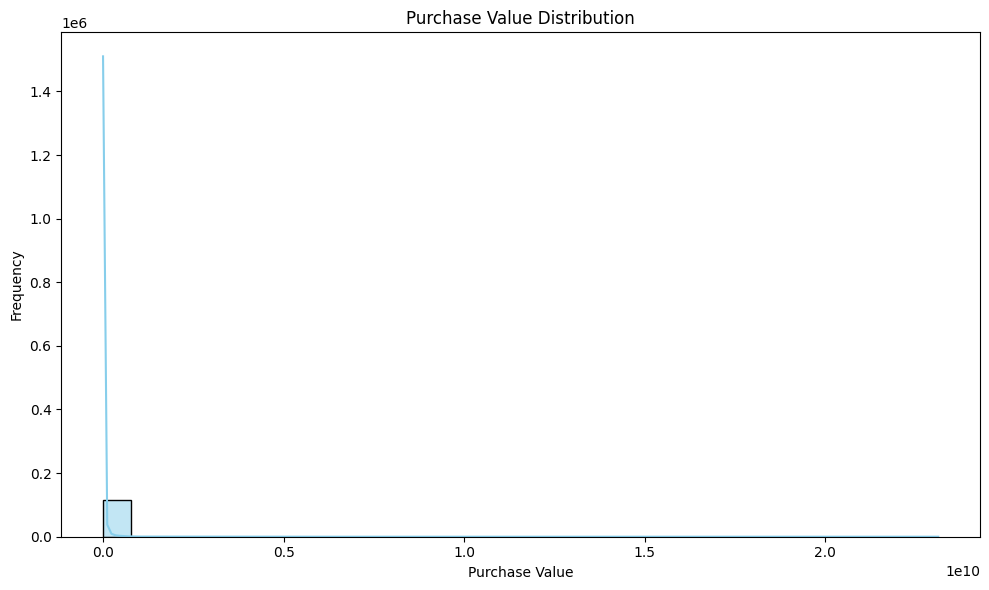

In [79]:
# Distribution of Target Variable i.e purchaseValue

plt.figure(figsize=(10, 6))
sns.histplot(tr_data['purchaseValue'], bins=30, kde=True, color='skyblue')
plt.title('Purchase Value Distribution')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 4.2 Correlation Heatmap

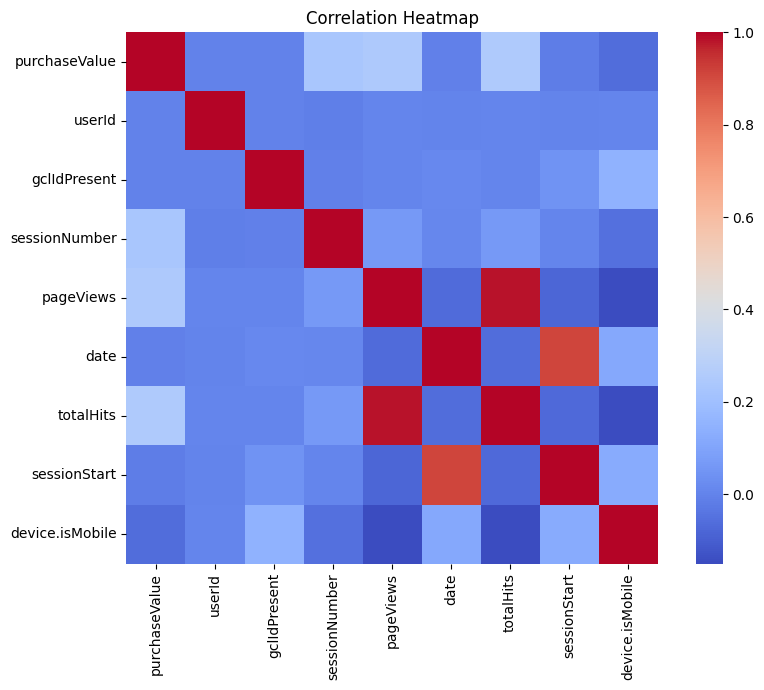

In [80]:
numeric_data = tr_data.select_dtypes(include=['number'])
correlation = numeric_data.corr()

plt.figure(figsize=(9, 7))
sns.heatmap(correlation, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# 4.3 KDE Plot Graph

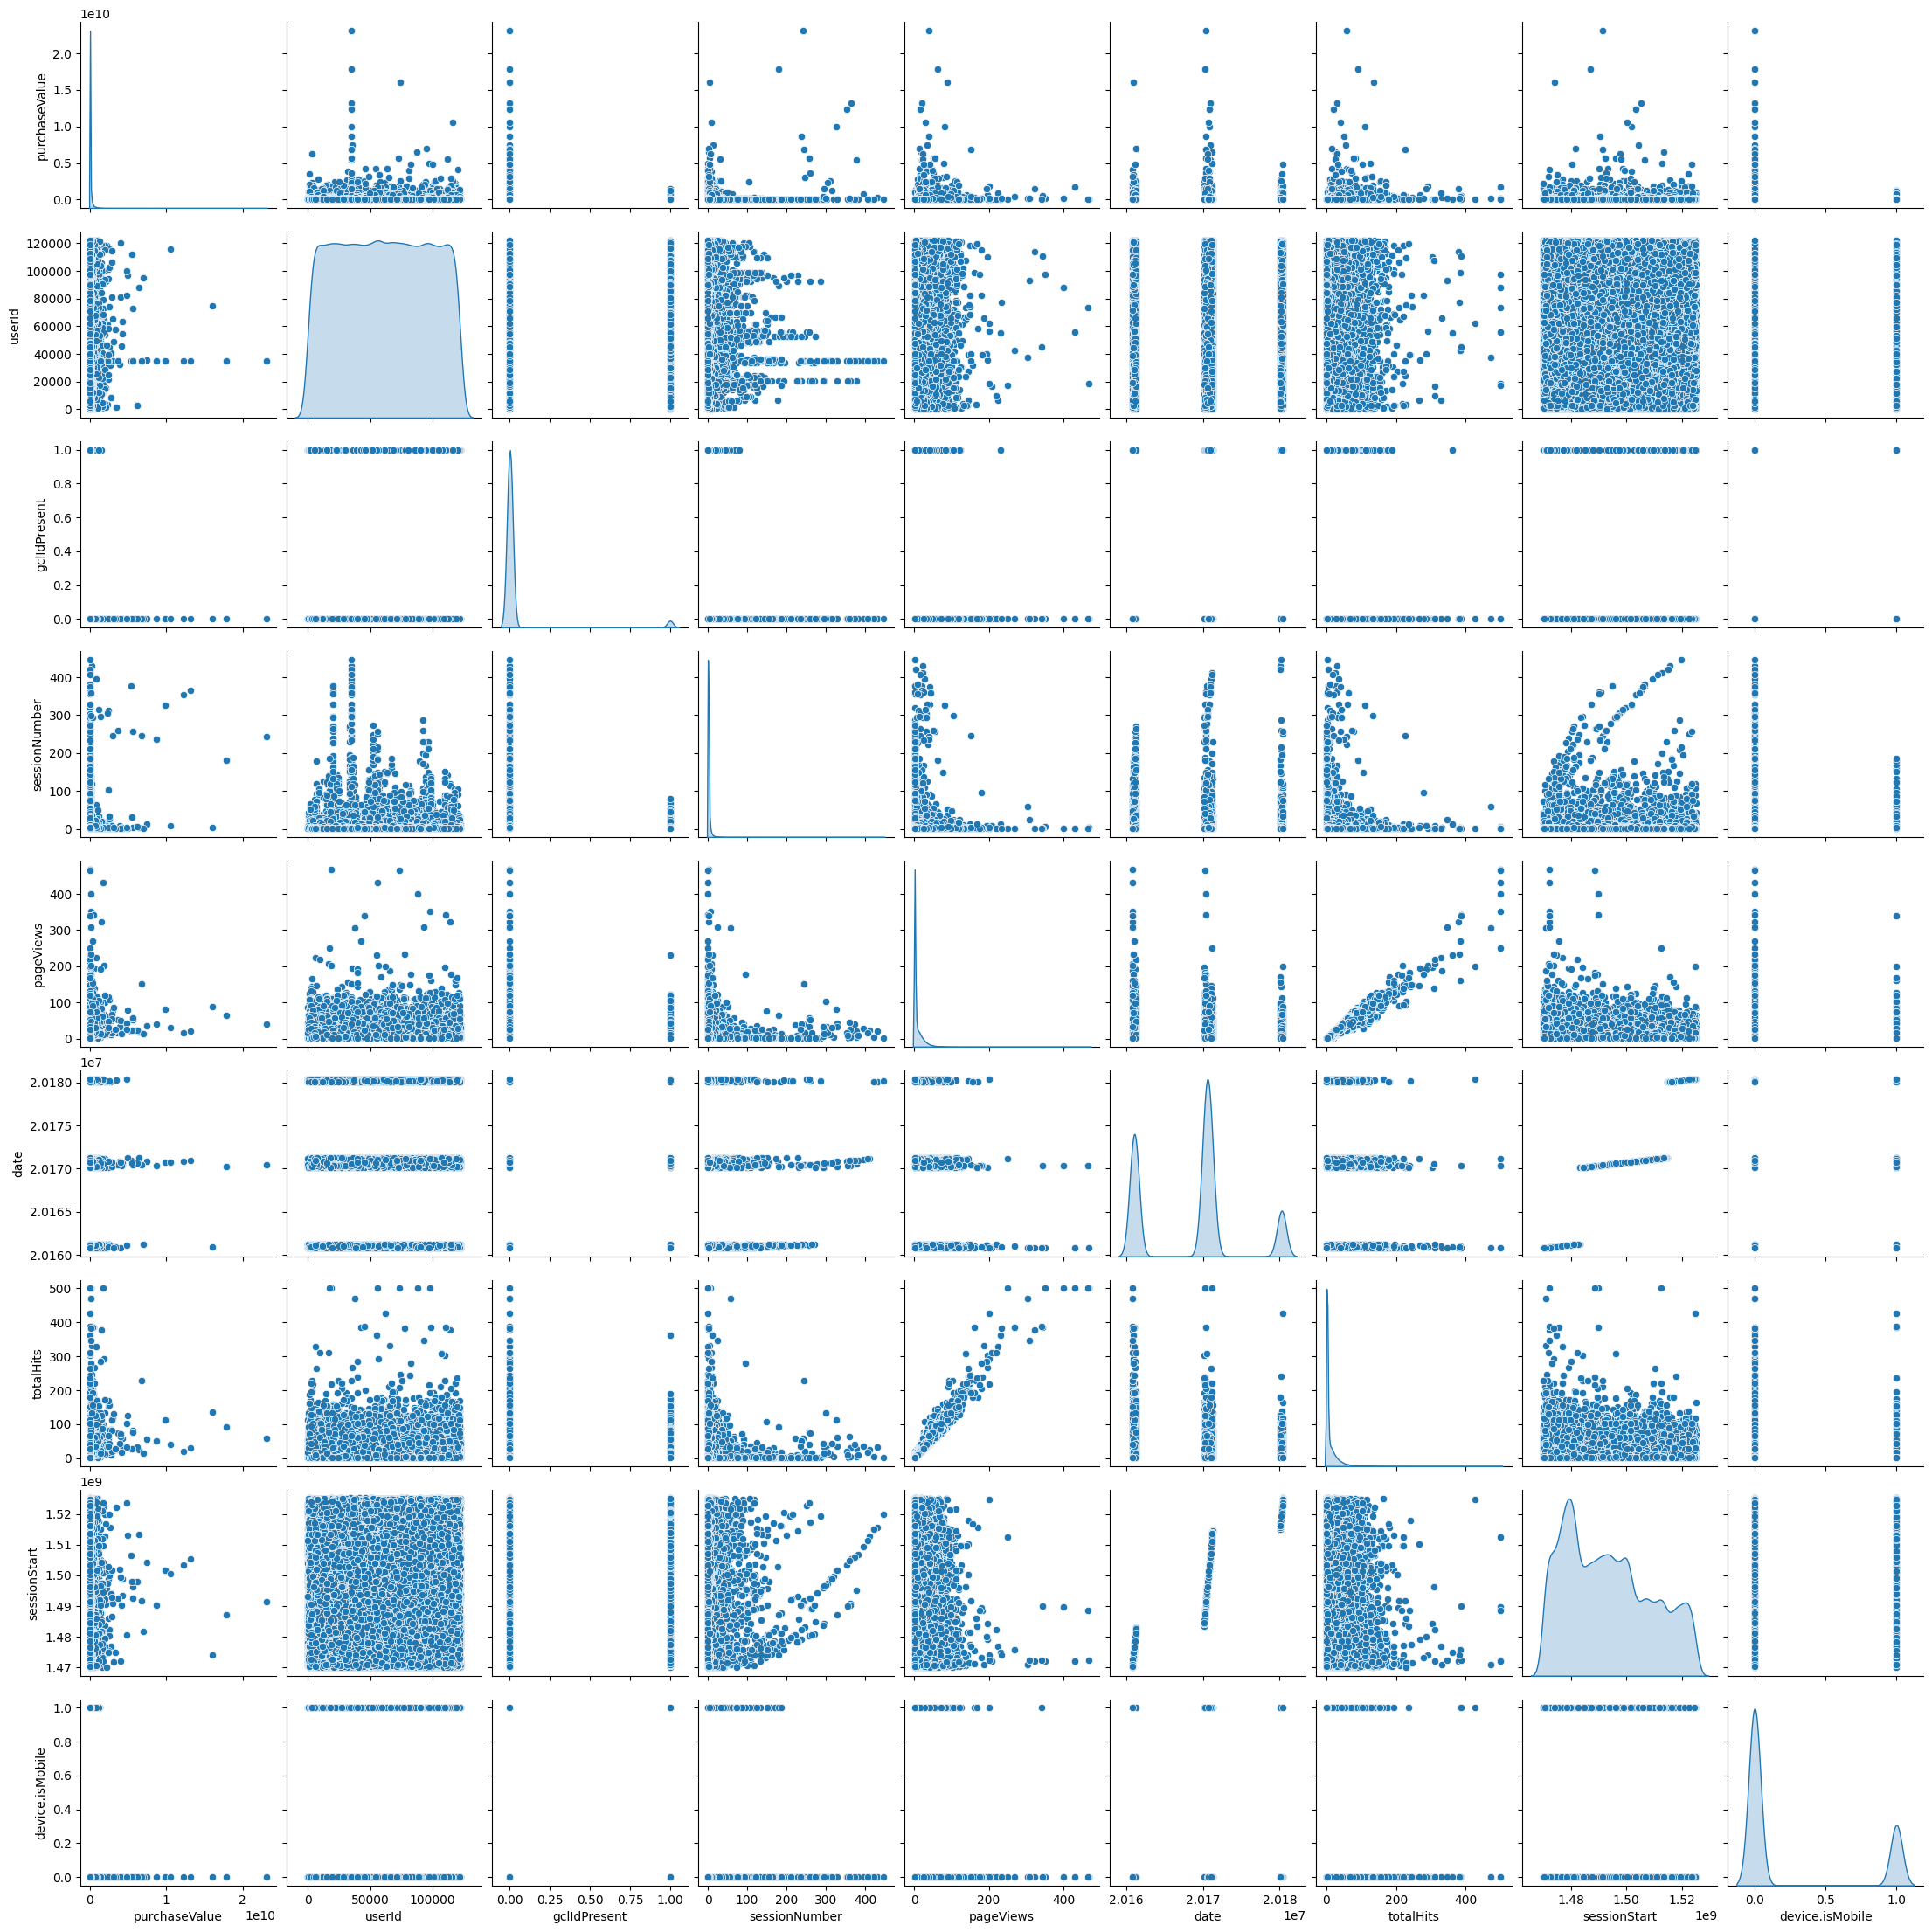

In [81]:
sns.pairplot(tr_data, diag_kind="kde")

# 4.4 Purchase over time(Time-Series Plot).

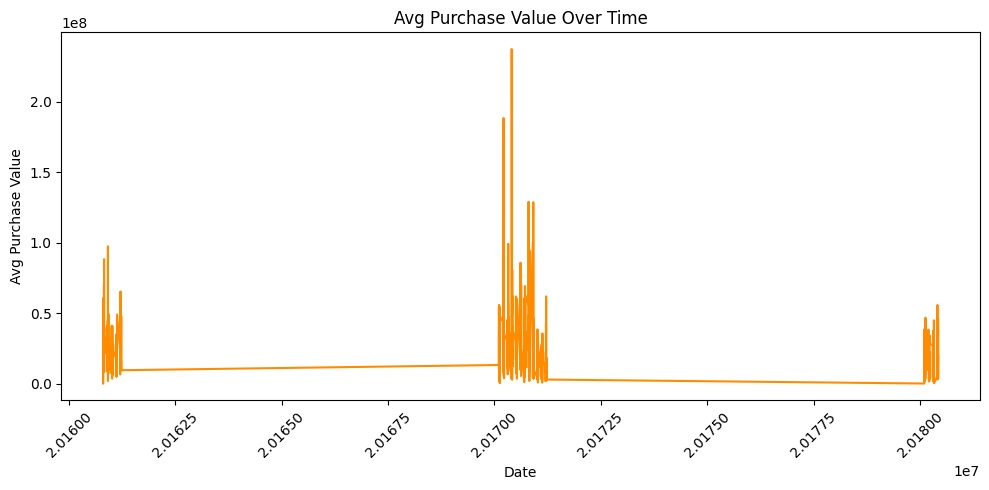

In [82]:
avg_purchase = tr_data.groupby('date')['purchaseValue'].mean()

plt.figure(figsize=(10, 5))
plt.plot(avg_purchase, color='darkorange')
plt.title('Avg Purchase Value Over Time')
plt.xlabel('Date')
plt.ylabel('Avg Purchase Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Feature Enginnering

In [83]:
user_features = {
    'user_pageViews_mean' : ('pageViews','mean'),
    'user_pageViews_sum' : ('pageViews','sum'),
    'user_hits_mean' : ('totalHits','mean'),
    'user_hits_sum' : ('totalHits','sum'),
    'user_session_count' : ('sessionNumber','max'),
    'user_purchase_mean' : ('purchaseValue','mean'),
    'user_purchase_sum' : ('purchaseValue','sum')
}

features = user_features

if features:
    user_features = tr_data.groupby('userId').agg(**features)
    
    tr_data = tr_data.merge(user_features,on='userId',how='left')
    te_data = te_data.merge(user_features,on='userId',how='left')
    te_data[user_features.columns]= te_data[user_features.columns].fillna(0)
    

# 5.1 User's last session date.

In [84]:
#Assigning the converted date time format to the original date column
tr_data['date']=tr_dates
te_data['date']=te_dates

In [85]:
user_last_session=tr_data.groupby('userId')['date'].max().to_dict()
tr_data['user_last_session']=tr_data['userId'].map(user_last_session)
te_data['user_last_session']=te_data['userId'].map(user_last_session)

# 5.2 Day's since last user session.

In [86]:
tr_data['days_since_last_session']= (tr_data['date'] - tr_data['user_last_session']).dt.days
te_data['days_since_last_session']= (te_data['date'] - te_data['user_last_session']).dt.days
te_data['days_since_last_session'].fillna(999, inplace=True)

# 5.3 User's active level or presence.

In [87]:
recent_cutoff= pd.Timedelta(days=30)
tr_data['user_recent_activity']= (tr_data['date'] - tr_data['user_last_session']) <= recent_cutoff
te_data['user_recent_activity']= (te_data['date'] - te_data['user_last_session']) <= recent_cutoff
te_data['user_recent_activity'].fillna(False,inplace = True)

In [88]:
for df in [tr_data,te_data]:
    if 'totalHits' in df.columns and 'pageViews' in df.columns:
        df['hit_per_view'] = df['totalHits'] / (df['pageViews']+ 1)
    if 'total.bounces' in df.columns and 'pageViews' in df.columns:
        df['bounce_rate'] = df['total.bounces'] / (df['pageViews']+ 1)

    #Converting boolean to numeric datatype.
    df['user_recent_activity']= df['user_recent_activity'].astype(int)

In [89]:
#Droppping userid to prevent data leakage.
tr_data.drop('userId', axis =1, inplace=True)
te_data.drop('userId', axis =1, inplace=True)

# Fetaure Classification

In [90]:
# Keeping only relevant features
exclude = ['purchaseValue', 'date', 'user_last_session']
feature_cols = [col for col in tr_data.columns if col not in exclude]

# Spliting features by type
num_features = [col for col in feature_cols if tr_data[col].dtype in [np.int64, np.float64]]
cat_features = [col for col in feature_cols if col not in num_features]


In [91]:
#Defining low cardinality and high cardinalty categorical features.

low_cardinality = []
high_cardinality = []

for col in cat_features:
    unique_vals = tr_data[col].nunique()
    if unique_vals <= 15:
        low_cardinality.append(col)
    else:
        high_cardinality.append(col)

print(f"Numerical features: {len(num_features)}")
print(f"Low-cardinality categorical: {len(low_cardinality)}")
print(f"High-cardinality categorical: {len(high_cardinality)}")

Numerical features: 16
Low-cardinality categorical: 6
High-cardinality categorical: 11


# 6 Data Preprocessing Pipeline.

In [92]:
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), num_features),
        
        ('cat_low', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ]), low_cardinality),
        
        ('cat_high', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), high_cardinality)
    ],
    remainder='passthrough'
)


# 7. Splitting the dataset. 

In [93]:
split_date = tr_data['date'].max() - pd.DateOffset(months=3)

train_set = tr_data[tr_data['date'] < split_date]
val_set = tr_data[tr_data['date'] >= split_date]

In [94]:
#X = tr_data[feature_cols]
#y = tr_data['purchaseValue']

#X_train, X_val, y_train, y_val = train_test_split(
 #   X, y, test_size=0.60, random_state=42, shuffle=True
#)

In [95]:
X_train = train_set[feature_cols]
y_train = train_set['purchaseValue']
X_val = val_set[feature_cols]
y_val = val_set['purchaseValue']
X_test = te_data[feature_cols]

In [96]:
#Printing the training and validation sets
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(104585, 33)
(11202, 33)
(104585,)
(11202,)


# 8. Building a Baseline Model

# 8.1 Mean Predictor Model (Baseline Model)

In [97]:
# Baseline model: predicting the mean of the dataset
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train, y_train)

#Training the baseline model
train_set_prediction = baseline_model.predict(X_train)
val_set_prediction = baseline_model.predict(X_val)

# Evaluate on validation set
print("\nBaseline performance (mean predictor):")
print(" R2 :", round(r2_score(y_val, val_set_prediction), 4))
print(" MSE:", round(mean_squared_error(y_val, val_set_prediction), 4))
print(" MAE:", round(mean_absolute_error(y_val, val_set_prediction), 4))



Baseline performance (mean predictor):
 R2 : -0.0
 MSE: 2.0734366061340016e+16
 MAE: 43315823.053


In [98]:
individual_results = {}

# 8.2 Random Forest Model

In [99]:
#Defining the random forest regression model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Training and evaluating the model

In [100]:
#Training the model
rf_pipeline.fit(X_train, y_train)
y_predict_rf = rf_pipeline.predict(X_val)
y_predict_rf[y_predict_rf < 0] = 0  # Ensuress non-negative predictions

#Evaluating the model
rf_r2 = r2_score(y_val, y_predict_rf)
rf_mse = mean_squared_error(y_val, y_predict_rf)
rf_mae = mean_absolute_error(y_val, y_predict_rf)

print(f"Random Forest Results :")
print(f"  Validation R² Score: {rf_r2:.4f}")
print(f"  Validation MSE: {rf_mse:.4f}")
print(f"  Validation MAE: {rf_mae:.4f}")

individual_results['RandomForest'] = {
    'model': rf_pipeline,
    'R2': rf_r2,
    'MSE': rf_mse,
    'MAE': rf_mae
}


Random Forest Results :
  Validation R² Score: 0.7559
  Validation MSE: 5060907084904127.0000
  Validation MAE: 6037436.7881


# 8.3 LightGBM Model

In [101]:
#Defining the LightGBM Model
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', LGBMRegressor(random_state=42, verbose=-1))
])

# Training and evaluating the model

In [102]:
#Training the model
lgb_pipeline.fit(X_train, y_train)
y_predict_lgb = lgb_pipeline.predict(X_val)
y_predict_lgb[y_predict_lgb < 0] = 0  # Ensure non-negative predictions

#Evalauting the model
lgb_r2 = r2_score(y_val, y_predict_lgb)
lgb_mse = mean_squared_error(y_val, y_predict_lgb)
lgb_mae = mean_absolute_error(y_val, y_predict_lgb)

print(f"LightGBM Results:")
print(f"  Validation R² Score: {lgb_r2:.4f}")
print(f"  Validation MSE: {lgb_mse:.4f}")
print(f"  Validation MAE: {lgb_mae:.4f}")

individual_results['LightGBM'] = {
    'model': lgb_pipeline,
    'R2': lgb_r2,
    'MSE': lgb_mse,
    'MAE': lgb_mae
}

LightGBM Results:
  Validation R² Score: 0.6122
  Validation MSE: 8040531741338805.0000
  Validation MAE: 8075735.6508


# 8.4 XGBoost Model

In [103]:
#Defining the model
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Hyperparameter tuning

In [107]:
#Custom Hyperparameter Tuning
xgb_parameter_distribution = {
    'regressor__n_estimators': [200, 400, 500, 700],
    'regressor__max_depth': [1, 3, 6, 9, 12],
    'regressor__learning_rate': [0.01,0.02, 0.04, 0.05],
    'regressor__subsample': [0.5, 0.6, 0.7],
    'regressor__colsample_bytree': [0.4, 0.5, 0.6],
    'regressor__reg_alpha': [0.1, 0.5, 1.0,1.5,2.0],
    'regressor__reg_lambda': [0.05,0.75,0.1,0.3, 0.5]
}


xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_parameter_distribution,
    n_iter=20,
    scoring='r2',
    random_state=42,
    n_jobs=1,
    verbose=1
)

#Training the model
xgb_search.fit(X_train, y_train)
#Selecting the best parameters for this model
best_xgb_model = xgb_search.best_estimator_

y_predict_xgb = best_xgb_model.predict(X_val)
y_predict_xgb[y_predict_xgb < 0] = 0  # Ensure non-negative predictions

#Evaluation on dataset
xgb_r2 = r2_score(y_val, y_predict_xgb)
xgb_mse = mean_squared_error(y_val, y_predict_xgb)
xgb_mae = mean_absolute_error(y_val, y_predict_xgb)

print(f"\nXGBoost Results:")
print(f"  Validation R² Score: {xgb_r2:.4f}")
print(f"  Validation MSE: {xgb_mse:.4f}")
print(f"  Validation MAE: {xgb_mae:.4f}")
print(f"  Best Parameters: {xgb_search.best_params_}")

individual_results['XGBoost'] = {
    'model': best_xgb_model,
    'R2': xgb_r2,
    'MSE': xgb_mse,
    'MAE': xgb_mae
}

Fitting 5 folds for each of 20 candidates, totalling 100 fits

XGBoost Results:
  Validation R² Score: 0.5491
  Validation MSE: 9348402804423582.0000
  Validation MAE: 8307093.8524
  Best Parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0.05, 'regressor__reg_alpha': 2.0, 'regressor__n_estimators': 500, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 0.4}


# 9. Models Comparison

In [105]:
#Comparing all the models for better insight

comparison_results = []
for model_name, results in individual_results.items():
    comparison_results.append({
        'Model': model_name,
        'Val_R2': results['R2'],
        'Val_MSE': results['MSE'],
        'Val_MAE': results['MAE']
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Val_R2', ascending=False)

print(comparison_df.to_string(index=False))

       Model   Val_R2      Val_MSE      Val_MAE
     XGBoost 0.780651 4.548053e+15 6.540143e+06
RandomForest 0.755917 5.060907e+15 6.037437e+06
    LightGBM 0.612212 8.040532e+15 8.075736e+06


# 10. Submission

In [106]:
#Selecting the best model 
best_model_name = 'XGBoost'
final_model = individual_results[best_model_name]['model']

print(f"\nSelected best model: {best_model_name}")

# Retraining the model again on full dataset
X_full_train = tr_data[feature_cols]
y_full_train = tr_data['purchaseValue']

final_model.fit(X_full_train, y_full_train)

# Generating final predictions
final_predictions = final_model.predict(X_test)
final_predictions[final_predictions < 0] = 0  

#Submitting the final predictions 
submission = pd.DataFrame({
    "id": range(len(X_test)), 
    "purchaseValue": final_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission done successfully.")



Selected best model: XGBoost
Submission done successfully.
